# Bitcoin Price Prediction Using RNN

<p><strong>Name: </strong>Josiah Ball<br>
<strong>Date: </strong>4/28/2025<br>
<strong>Course: </strong>DTSA 5511</p>

<p>The purpose of this notebook is to glorify Jesus Christ by creating a recurrent neural network that can predict whether Bitcoin price in US Dollars will rise or fall the next day using data from the <a href="https://pypi.org/project/yfinance/" target="_blank">Yahoo! Finance python library</a>.[1] The intended audience of this project is my fellow students at the University of Colorado at Boulder.</p>

## The Problem

<p>The goal of this project is to create a recurrent neural network (RNN) that can take time-series data on Bitcoin's US Dollar pricing and predict whether the price will increase or decrease the following day. Lord willing, we will build and test three different models: one Long Short-Term Memory (LSTM) RNN, and one Gated Recurrent Unit (GRU) RNN. We will compare the performance of these models and choose the best performing one to optimize the hyperparameters and predict on a testing dataset.</p>

## The Dataset

<p>The data for this project comes from the <a href="https://pypi.org/project/yfinance/" target="_blank">Yahoo! Finance python library</a>.[2] This data library has stock market and other financial time-series datasets taken from <em>Yahoo! Finance</em> and made available through PyPI. Specifically, we will take data for Bitcoin prices in US Dollars from the last 10 years (April 25, 2015) to train, validate, and test the models.</p>

## Notebook Set-Up

In [ ]:
# Install Libraries
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.0 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import numpy as np
import keras_tuner as kt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Activation, GRU
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

In [ ]:
# Ensure TPU or GPU Usage
try:
    # Check for TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print(f"✅ TPU detected: {tpu.cluster_spec().as_dict()}")
except ValueError:
    # No TPU found, check for GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        strategy = tf.distribute.MirroredStrategy()
        print(f"✅ GPU detected: {gpus[0].name}")
    else:
        # No GPU found, use CPU
        strategy = tf.distribute.get_strategy()
        print("⚙️ No TPU or GPU detected. Using CPU.")

✅ GPU detected: /physical_device:GPU:0


# Exploratory Data Analysis

<p>The first step in any data science project is to download, inspect, and clean the data.</p>

In [ ]:
# Download 10 years of Bitcoin data
df = yf.download('BTC-USD', start='2015-04-23', end='2025-04-22')

# Explore Basics of Training Dataset
print(df.shape)
print(df.info())
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


(3652, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3652 entries, 2015-04-23 to 2025-04-21
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   3652 non-null   float64
 1   (High, BTC-USD)    3652 non-null   float64
 2   (Low, BTC-USD)     3652 non-null   float64
 3   (Open, BTC-USD)    3652 non-null   float64
 4   (Volume, BTC-USD)  3652 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 171.2 KB
None


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-04-23,236.462006,236.475006,233.199005,234.052994,17036000
2015-04-24,231.268005,236.304993,229.932999,235.970001,21448700
2015-04-25,226.389999,232.561005,226.337006,231.235001,13957200
2015-04-26,219.429993,226.944000,214.873993,226.410004,28943700
2015-04-27,229.285995,233.304993,218.022995,219.429001,38574000


<p><strong>NOTE: </strong>There are no null values in any of the columns, so no null-handling is required.</p>

In [ ]:
# Remove the information from the column name after the comma in each
df.columns = [col[0] for col in df.columns]
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-04-23,236.462006,236.475006,233.199005,234.052994,17036000
2015-04-24,231.268005,236.304993,229.932999,235.970001,21448700
2015-04-25,226.389999,232.561005,226.337006,231.235001,13957200
2015-04-26,219.429993,226.944000,214.873993,226.410004,28943700
2015-04-27,229.285995,233.304993,218.022995,219.429001,38574000


In [ ]:
# Move the date column from the index into the first column
df.reset_index(inplace=True)
df.head()

,Date,Close,High,Low,Open,Volume
0,2015-04-23,236.462006,236.475006,233.199005,234.052994,17036000
1,2015-04-24,231.268005,236.304993,229.932999,235.970001,21448700
2,2015-04-25,226.389999,232.561005,226.337006,231.235001,13957200
3,2015-04-26,219.429993,226.944000,214.873993,226.410004,28943700
4,2015-04-27,229.285995,233.304993,218.022995,219.429001,38574000


In [ ]:
# Check range of values for each column
df.describe()

,Date,Close,High,Low,Open,Volume
count,3652,3652.000000,3652.000000,3652.000000,3652.000000,3.652000e+03
mean,2020-04-21 11:59:59.999999744,22921.104500,23406.193843,22364.552376,22898.454656,2.042496e+10
min,2015-04-23 00:00:00,210.494995,225.718994,199.567001,210.067993,1.060090e+07
25%,2017-10-21 18:00:00,3841.825317,3905.769531,3702.230896,3829.647522,2.720682e+09
50%,2020-04-21 12:00:00,10579.554688,10822.932129,10256.054199,10576.649414,1.688781e+10
75%,2022-10-21 06:00:00,37335.182617,38349.862305,36216.660156,37328.868164,3.131190e+10
max,2025-04-21 00:00:00,106146.265625,109114.882812,105291.734375,106147.296875,3.509679e+11
std,NaN,25089.812721,25601.972029,24510.884577,25071.314535,2.088152e+10


<Axes: xlabel='Date'>

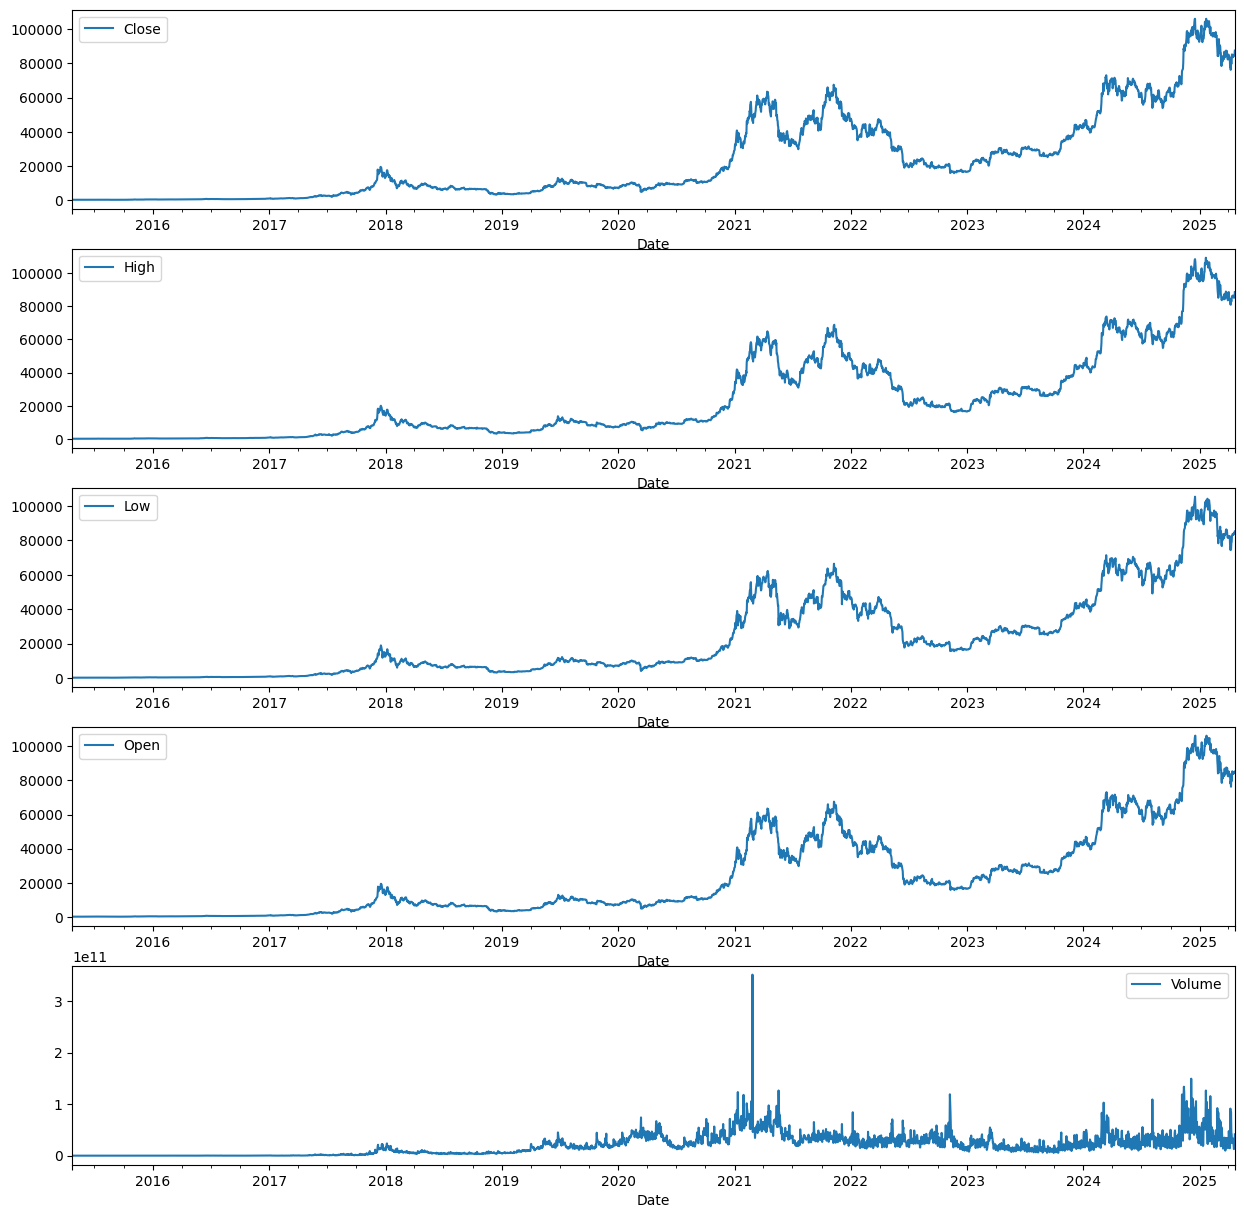

In [ ]:
# Plot five line graphs showing the Close, High, Low, Open, and volume columns mapped over the Date field
fig, ax = plt.subplots(5, 1, figsize=(15, 15))
df.plot(x='Date', y='Close', ax=ax[0])
df.plot(x='Date', y='High', ax=ax[1])
df.plot(x='Date', y='Low', ax=ax[2])
df.plot(x='Date', y='Open', ax=ax[3])
df.plot(x='Date', y='Volume', ax=ax[4])

<Axes: >

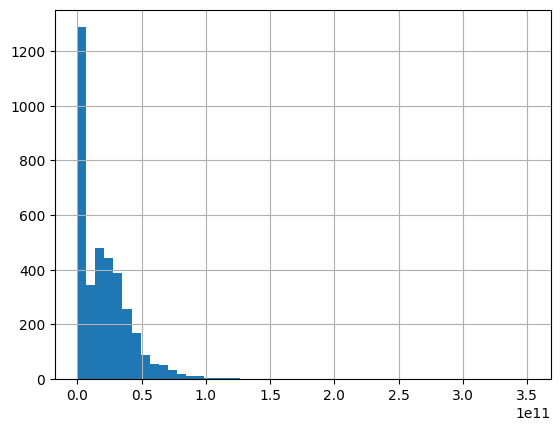

In [ ]:
# Create a histogram for the volume column
df['Volume'].hist(bins=50)

In [ ]:
# Check data types for each column
df.dtypes

,0
Date,datetime64[ns]
Close,float64
High,float64
Low,float64
Open,float64
Volume,int64


Has Duplicates: False
Axes(0.125,0.11;0.775x0.77)


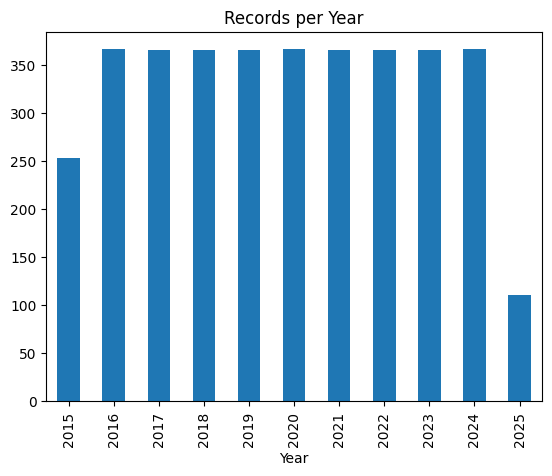

In [ ]:
# Check for any duplicate dates
df_temp = df.copy()
duplicates = df_temp['Date'].duplicated()
has_duplicates = duplicates.any()
print(f'Has Duplicates: {has_duplicates}')

# Check for any gaps in data
df_temp['Year'] = df['Date'].dt.year
print(df_temp.groupby('Year').size().plot(kind='bar', title='Records per Year'))


<p><strong>NOTE: </strong>the shortages for 2015 and 2025 are due to my ten year window beginning in April 2015 and ending in April 2025, so this (paired with having no duplicates) tells us the data is correct.</p>

<Axes: title={'center': 'Daily Change %'}>

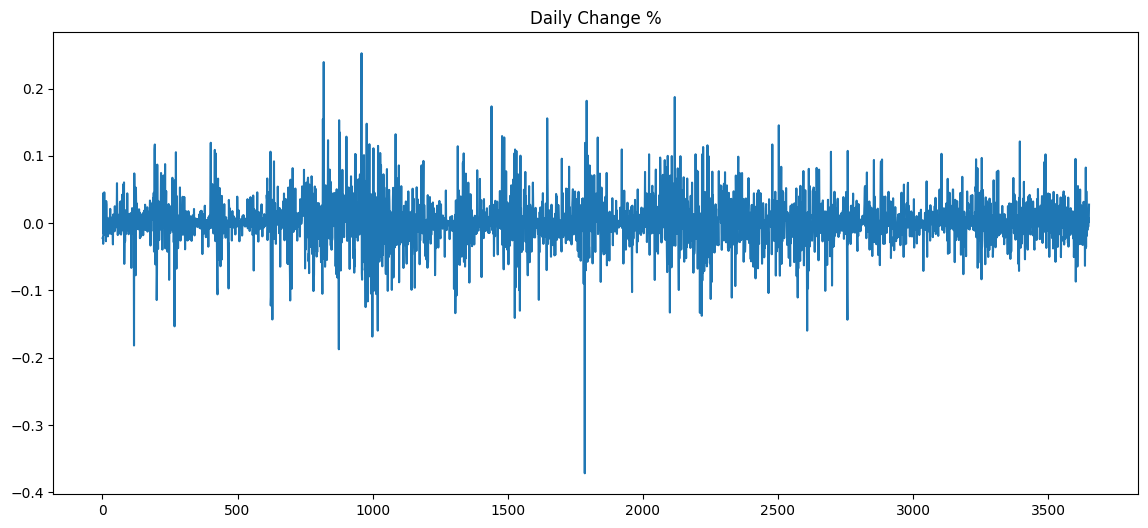

In [ ]:
# Create and inspect how much the close rate changes
df['Change_From_Prev'] = df['Close'].pct_change()
df['Change_From_Prev'].plot(figsize=(14,6), title='Daily Change %')

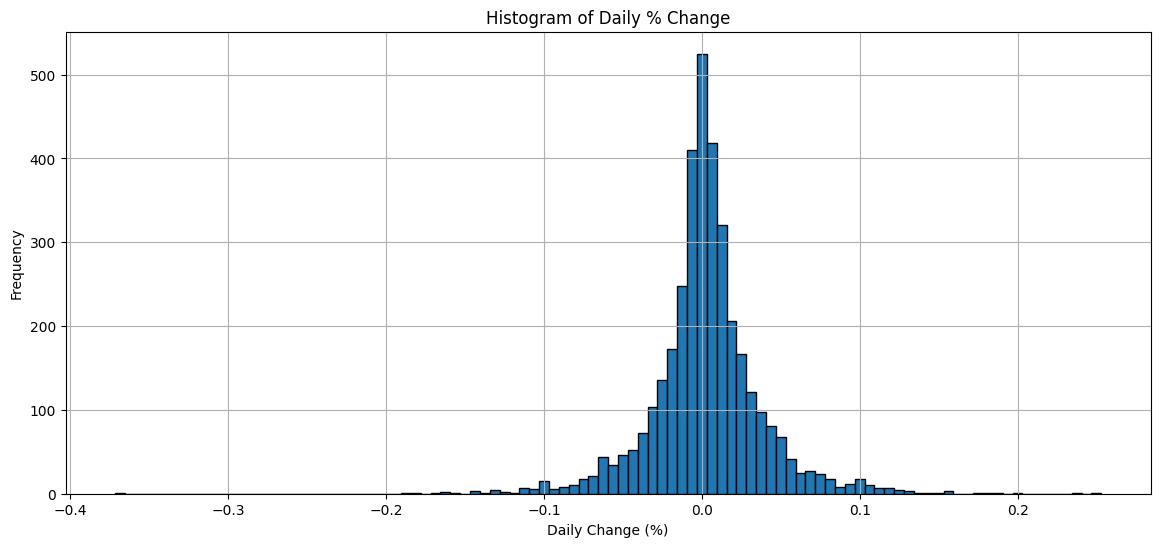

In [ ]:
# Plot histogram of change %
plt.figure(figsize=(14,6))
plt.hist(df['Change_From_Prev'].dropna(), bins=100, edgecolor='black')
plt.title('Histogram of Daily % Change')
plt.xlabel('Daily Change (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<p><strong>NOTE: </strong>While there are outliers, the vast majority of days have between -0.1% and 0.1% change, meaning this (surprisingly) is not super volitile day-to-day.

Axes(0.125,0.11;0.775x0.77)


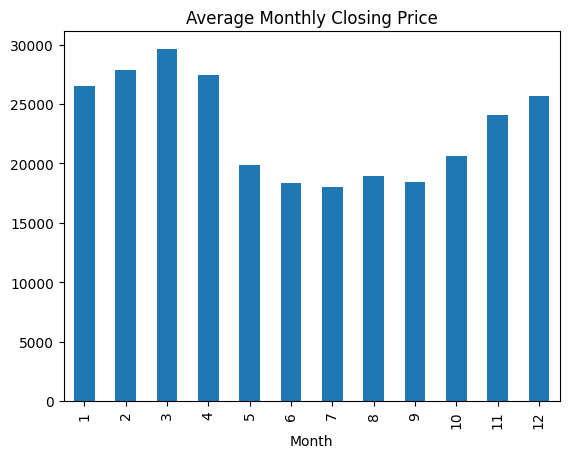

In [ ]:
# Check for seasonality
df_temp = df.copy()
df_temp['Month'] = df['Date'].dt.month
print(df_temp.groupby('Month')['Close'].mean().plot(kind='bar', title='Average Monthly Closing Price'))

Axes(0.125,0.11;0.775x0.77)


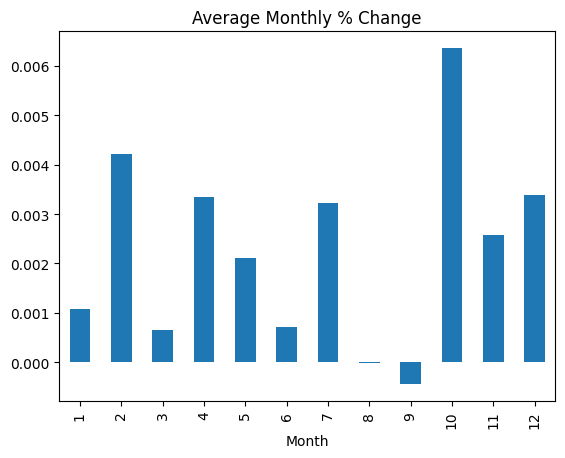

In [ ]:
print(df_temp.groupby('Month')['Change_From_Prev'].mean().plot(kind='bar', title='Average Monthly % Change'))

<p><strong>NOTE: </strong>We see from this that there is some seasonality to Bitcoin prices, where the value is (usually) increasing and thus higher in October-February. This could mean that the month is a helpful variable for the model to consider, so we will add it as a column in df.</p>

In [ ]:
# Add 'Month' column
df['Month'] = df['Date'].dt.month
df.head()

,Date,Close,High,Low,Open,Volume,Change_From_Prev,Month
0,2015-04-23,236.462006,236.475006,233.199005,234.052994,17036000,NaN,4
1,2015-04-24,231.268005,236.304993,229.932999,235.970001,21448700,-0.021965,4
2,2015-04-25,226.389999,232.561005,226.337006,231.235001,13957200,-0.021092,4
3,2015-04-26,219.429993,226.944000,214.873993,226.410004,28943700,-0.030743,4
4,2015-04-27,229.285995,233.304993,218.022995,219.429001,38574000,0.044916,4


In [ ]:
# Add simple rolling averages
df['SMA10'] = df['Close'].rolling(window=10).mean()
df['SMA30'] = df['Close'].rolling(window=30).mean()

# Drop NaN by dropping first rows
df = df.dropna()

df.head()

,Date,Close,High,Low,Open,Volume,Change_From_Prev,Month,SMA10,SMA30
29,2015-05-22,240.348007,240.968994,235.059998,235.320999,27003000,0.021263,5,235.865102,234.939267
30,2015-05-23,238.871994,241.024994,238.690994,240.285995,14605000,-0.006141,5,236.114601,235.019600
31,2015-05-24,240.953003,241.977997,238.811005,238.975998,11508000,0.008712,5,236.517001,235.342434
32,2015-05-25,237.110001,241.020996,236.636993,240.927002,14423900,-0.015949,5,236.467502,235.699767
33,2015-05-26,237.115997,238.242004,235.692001,237.104004,16425000,0.000025,5,236.563802,236.289301


<Axes: xlabel='Date'>

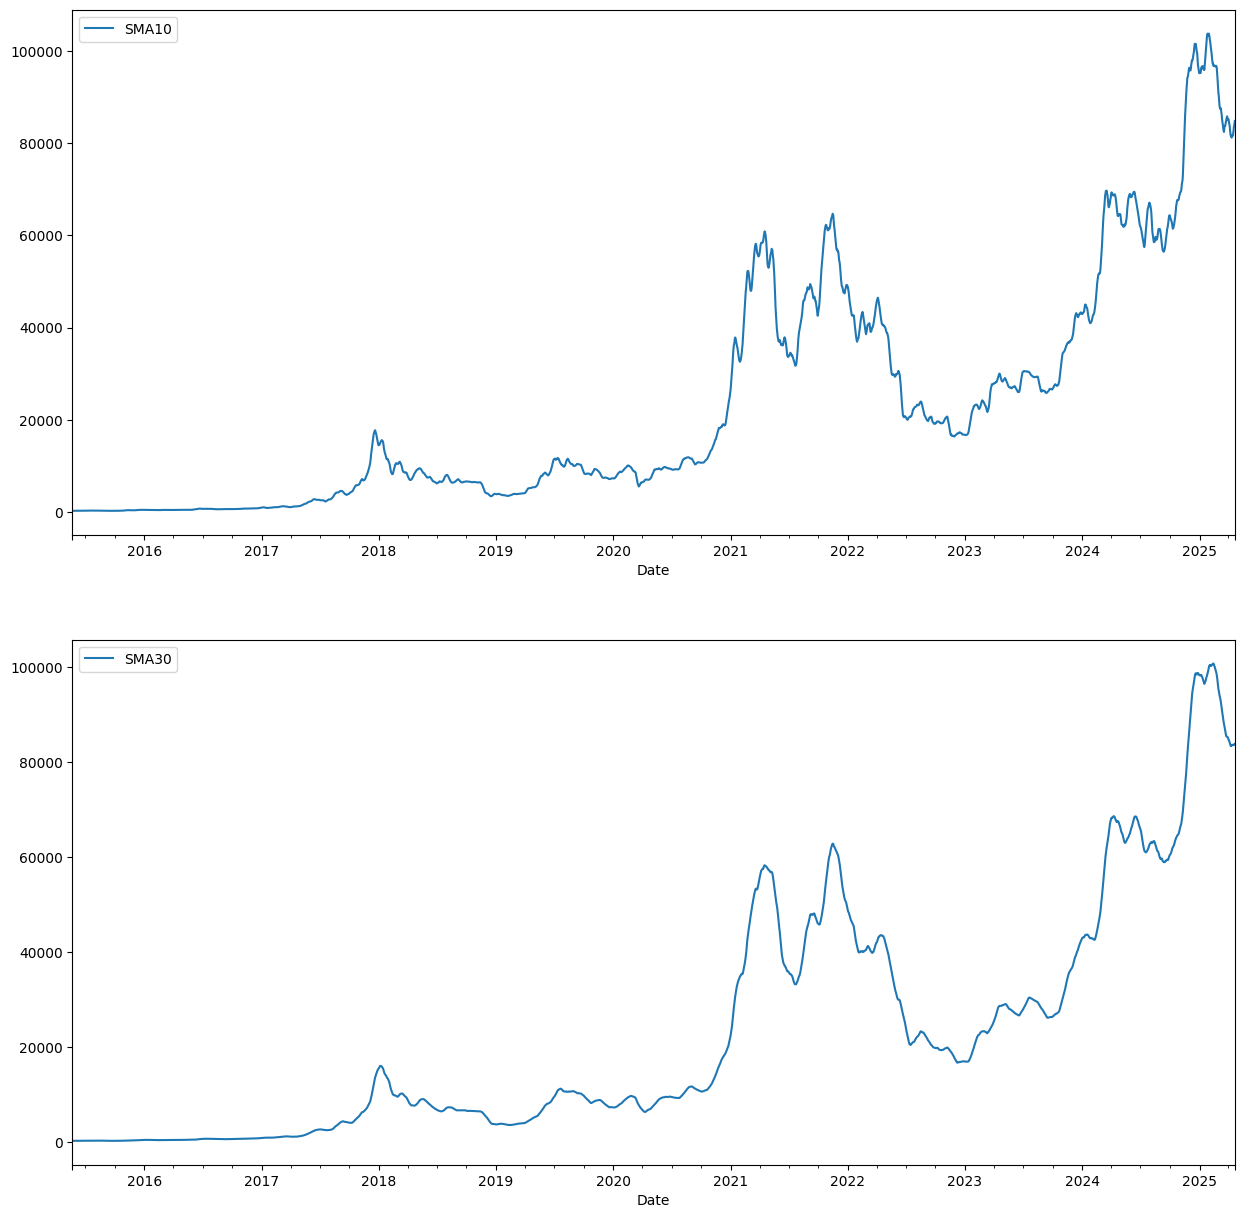

In [ ]:
# Graph simples rolling averages over time
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
df.plot(x='Date', y='SMA10', ax=ax[0])
df.plot(x='Date', y='SMA30', ax=ax[1])

Text(0.5, 1.0, 'Feature Correlation Matrix')

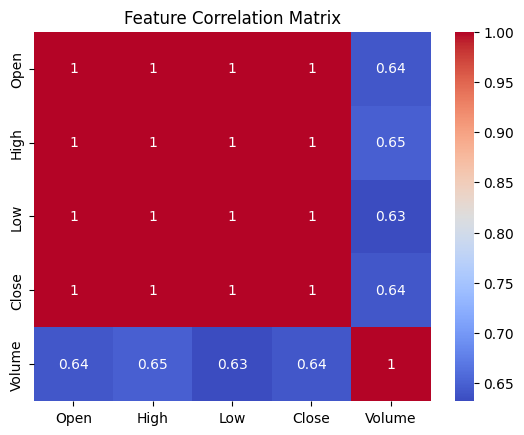

In [ ]:
# Check for multicolinearity
corr = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')

<p><strong>NOTE: </strong>Unsurprisingly, the "Open", "High", "Low", and "Close" columns are highly (perfectly) colinear. This means these features are not independent and therefore redundant. We will use only the "Close" column, while creating a "High-Low Range" column to capture the volitility of that day.</p>

In [ ]:
# Create High_Low_Range Column
df['High_Low_Range'] = (df['High'] - df['Low']) / df['Open']
df.head()

<ipython-input-21-2729fa06bccf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['High_Low_Range'] = (df['High'] - df['Low']) / df['Open']


,Date,Close,High,Low,Open,Volume,Change_From_Prev,Month,SMA10,SMA30,High_Low_Range
29,2015-05-22,240.348007,240.968994,235.059998,235.320999,27003000,0.021263,5,235.865102,234.939267,0.025110
30,2015-05-23,238.871994,241.024994,238.690994,240.285995,14605000,-0.006141,5,236.114601,235.019600,0.009713
31,2015-05-24,240.953003,241.977997,238.811005,238.975998,11508000,0.008712,5,236.517001,235.342434,0.013252
32,2015-05-25,237.110001,241.020996,236.636993,240.927002,14423900,-0.015949,5,236.467502,235.699767,0.018196
33,2015-05-26,237.115997,238.242004,235.692001,237.104004,16425000,0.000025,5,236.563802,236.289301,0.010755


In [ ]:
# Drop redundant columns
df = df.drop(['High', 'Low', 'Open'], axis=1)
df.head()

,Date,Close,Volume,Change_From_Prev,Month,SMA10,SMA30,High_Low_Range
29,2015-05-22,240.348007,27003000,0.021263,5,235.865102,234.939267,0.025110
30,2015-05-23,238.871994,14605000,-0.006141,5,236.114601,235.019600,0.009713
31,2015-05-24,240.953003,11508000,0.008712,5,236.517001,235.342434,0.013252
32,2015-05-25,237.110001,14423900,-0.015949,5,236.467502,235.699767,0.018196
33,2015-05-26,237.115997,16425000,0.000025,5,236.563802,236.289301,0.010755


<p><strong>NOTE: </strong>Lastly, since the scope of our problem is to predict whether the value of Bitcoin will increase (1) or decrease (0) the <em>following</em> day, we will add a "target" column to be our training labels.

In [ ]:
# Add "Target" Column
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop NaN by dropping last row
df = df.dropna()
df.head()

,Date,Close,Volume,Change_From_Prev,Month,SMA10,SMA30,High_Low_Range,Target
29,2015-05-22,240.348007,27003000,0.021263,5,235.865102,234.939267,0.025110,0
30,2015-05-23,238.871994,14605000,-0.006141,5,236.114601,235.019600,0.009713,1
31,2015-05-24,240.953003,11508000,0.008712,5,236.517001,235.342434,0.013252,0
32,2015-05-25,237.110001,14423900,-0.015949,5,236.467502,235.699767,0.018196,1
33,2015-05-26,237.115997,16425000,0.000025,5,236.563802,236.289301,0.010755,1


<Axes: title={'center': 'Class Distribution'}, xlabel='Target'>

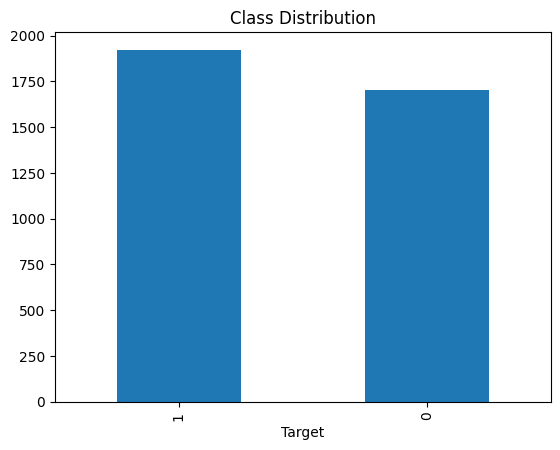

In [ ]:
# Graph class distribution of "Terget" Column
df['Target'].value_counts().plot(kind='bar', title='Class Distribution')

In [ ]:
print(df['Target'].value_counts()/len(df))

Target
1    0.5305
0    0.4695
Name: count, dtype: float64


<p><strong>NOTE: </strong>The target field is not particularly imbalanced, so we will proceed as-is. Next, we will normalize the input data.</p>

In [ ]:
# Normalize input data
FEATURE_COLUMNS = ['Close', 'Volume', 'Change_From_Prev', 'High_Low_Range', 'Month', 'SMA10', 'SMA30']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[FEATURE_COLUMNS])

df_scaled = pd.DataFrame(scaled_features, index=df.index, columns=FEATURE_COLUMNS)
df_scaled['Target'] = df['Target']
df_scaled['Date'] = df['Date']
df_scaled.head()

,Close,Volume,Change_From_Prev,High_Low_Range,Month,SMA10,SMA30,Target,Date
29,-0.910705,-0.984652,0.531089,-0.523601,-0.444481,-0.910923,-0.910639,0,2015-05-22
30,-0.910764,-0.985245,-0.235532,-0.955709,-0.444481,-0.910913,-0.910635,1,2015-05-23
31,-0.910681,-0.985394,0.179981,-0.856391,-0.444481,-0.910896,-0.910622,0,2015-05-24
32,-0.910834,-0.985254,-0.509913,-0.717638,-0.444481,-0.910898,-0.910608,1,2015-05-25
33,-0.910834,-0.985158,-0.063025,-0.926483,-0.444481,-0.910895,-0.910584,1,2015-05-26


<p><strong>NOTE: </strong>Now, our dataset is fully ready for use. The last thing to do is pslit it into training, validation, and testing datasets. Note that since this is a sequential model, we cann assign records randomly into the model, as it would have the benefit of "seeing into the future." Our model will be built on early data, validated on middle data, and tested on the most recent data.</p>

In [ ]:
# Calculate split indices
train_size = int(len(df_scaled) * 0.7)
val_size = int(len(df_scaled) * 0.15)

# Split the dataset
train = df_scaled.iloc[:train_size]
val = df_scaled.iloc[train_size:train_size + val_size]
test = df_scaled.iloc[train_size + val_size:]

print(f"Train shape: {train.shape}")
print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")

Train shape: (2536, 9)
Validation shape: (543, 9)
Test shape: (544, 9)


In [ ]:
# Prepare dataset --NOTE: I am very reliant on Chat GPT for this code[3]
TIME_STEPS = 90

X_train = train[FEATURE_COLUMNS]
y_train = train['Target']

X_val = val[FEATURE_COLUMNS]
y_val = val['Target']

X_test = test[FEATURE_COLUMNS]
y_test = test['Target']

def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

train_X, train_y = create_sequences(X_train, y_train, TIME_STEPS)
val_X, val_y = create_sequences(X_val, y_val, TIME_STEPS)
test_X, test_y = create_sequences(X_test, y_test, TIME_STEPS)

# Building Models

<p>Next, (Lord willing) we will build and compare two models: one Long Short-Term Memory (LTSM) RNN, and one Gated Recurrent Unit (GRU) RNN. Then we will compare the performance of these models, and then we will tune the hyperparameters of the better performing model.</p>

<p>The initial hyperparameters for the model comparison are given below as general "good guesses":</p>

<ul>
    <li>Long Short-Term Memory (LTSM) RNN
        <ul>
            <li>Number of units in the RNN layer: 64</li>
            <li>Architecture: Include dropout and batch normalization to reduce overfitting</li>
            <li>Optimizing Method: Adam</li>
            <li>Loss Function: Binary Cross Entropy</li>
            <li>Evaluation Metrics: Accuracy, Precision, and Recall</li>
        </ul>
    </li>
    <li>Gated Recurrent Unit (GRU) RNN
        <ul>
            <li>Number of units in the RNN layer: 64</li>
            <li>Architecture: Include dropout and batch normalization to reduce overfitting</li>
            <li>Optimizing Method: Adam</li>
            <li>Loss Function: Binary Cross Entropy</li>
            <li>Evaluation Metrics: Accuracy, Precision, and Recall</li>
        </ul>
        </ul>
    </li>
</ul>

## Model 1: Long Short-Term Memory (LTSM) RNN

In [ ]:
# Build LTSM Model
ltsm_model = keras.Sequential([
    layers.Input(shape=(TIME_STEPS, train_X.shape[2])),
    layers.LSTM(64, return_sequences=False),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
ltsm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

ltsm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,753 (73.25 KB)

 Trainable params: 18,625 (72.75 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Set up model checkpoints
ltsm_checkpoint = ModelCheckpoint(
    filepath='ltsm_best_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Fit the model
ltsm_history = ltsm_model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[ltsm_checkpoint, early_stopping]
)

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5057 - loss: 0.8176 - precision: 0.5506 - recall: 0.5355
Epoch 1: val_accuracy improved from -inf to 0.47020, saving model to ltsm_best_model.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5056 - loss: 0.8175 - precision: 0.5504 - recall: 0.5357 - val_accuracy: 0.4702 - val_loss: 0.7022 - val_precision: 0.4702 - val_recall: 1.0000
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5151 - loss: 0.7642 - precision: 0.5491 - recall: 0.5945
Epoch 2: val_accuracy did not improve from 0.47020
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5152 - loss: 0.7641 - precision: 0.5492 - recall: 0.5948 - val_accuracy: 0.4702 - val_loss: 0.7087 - val_precision: 0.4702 - val_recall: 1.0000
Epoch 3/30
72/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5160 - loss: 0.7443 - precision: 0.5577 - recall: 0.6255
Epoch 3: val_accuracy did not improve from 0.47020
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5162 - loss: 0.7447 - precision: 0.5573 - recall: 0.6267 - val_accuracy: 0.4702 - val_loss: 0.7096 - val_precision: 0.4702 - val_recall: 1.0000
Epoch 4/30
74/77 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5164 - loss: 0.7440 - precision: 0.5465 - recall: 0.6391 - val_accuracy: 0.4857 - val_loss: 0.7064 - val_precision: 0.4662 - val_recall: 0.6479
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5206 - loss: 0.7292 - precision: 0.5385 - recall: 0.6436
Epoch 6: val_accuracy did not improve from 0.48565
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5206 - loss: 0.7292 - precision: 0.5388 - recall: 0.6434 - val_accuracy: 0.4790 - val_loss: 0.7052 - val_precision: 0.4667 - val_recall: 0.7559
Epoch 7/30
72/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5434 - loss: 0.7104 - precision: 0.5668 - recall: 0.6690
Epoch 7: val_accuracy did not improve from 0.48565
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5429 - loss: 0.7108 - precision: 0.5667 - recall: 0.6695 - val_accuracy: 0.4724 - val_loss: 0.7049 - val_precision: 0.4611 - val_recall: 0.7230
Epoch 8/30
74/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.

## Model 2: Gated Recurrent Unit (GRU) RNN

<p><strong>NOTE: </strong>All the hyperparameters are the same as in the LTSM RNN. The only difference is that this is a GRU RNN.

In [ ]:
# Build GRU model
gru_model = keras.Sequential([
    layers.Input(shape=(TIME_STEPS, train_X.shape[2])),

    layers.GRU(64, return_sequences=False),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')
])

# Compile the model
gru_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Print model summary
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,209 (55.50 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Set up model checkpoints
gru_checkpoint = ModelCheckpoint(
    filepath='gru_best_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

# Fit the model
gru_history = gru_model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[gru_checkpoint, early_stopping]
)

Epoch 1/30
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5169 - loss: 0.7788 - precision: 0.5574 - recall: 0.5436
Epoch 1: val_accuracy improved from -inf to 0.47241, saving model to gru_best_model.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5171 - loss: 0.7780 - precision: 0.5576 - recall: 0.5457 - val_accuracy: 0.4724 - val_loss: 0.7014 - val_precision: 0.4712 - val_recall: 1.0000
Epoch 2/30
72/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5259 - loss: 0.7476 - precision: 0.5540 - recall: 0.6168
Epoch 2: val_accuracy did not improve from 0.47241
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5254 - loss: 0.7490 - precision: 0.5540 - recall: 0.6170 - val_accuracy: 0.4702 - val_loss: 0.7031 - val_precision: 0.4702 - val_recall: 1.0000
Epoch 3/30
72/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5089 - loss: 0.7719 - precision: 0.5371 - recall: 0.6376
Epoch 3: val_accuracy did not improve from 0.47241
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5088 - loss: 0.7714 - precision: 0.5377 - recall: 0.6367 - val_accuracy: 0.4724 - val_loss: 0.7104 - val_precision: 0.4695 - val_recall: 0.9390
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5095 - loss: 0.7341 - precision: 0.5405 - recall: 0.6312 - val_accuracy: 0.4768 - val_loss: 0.7093 - val_precision: 0.4733 - val_recall: 1.0000
Epoch 6/30
75/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5620 - loss: 0.7175 - precision: 0.5888 - recall: 0.6951
Epoch 6: val_accuracy did not improve from 0.47682
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5618 - loss: 0.7174 - precision: 0.5885 - recall: 0.6950 - val_accuracy: 0.4724 - val_loss: 0.7014 - val_precision: 0.4599 - val_recall: 0.6995
Epoch 7/30
72/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5116 - loss: 0.7289 - precision: 0.5531 - recall: 0.6324
Epoch 7: val_accuracy improved from 0.47682 to 0.48344, saving model to gru_best_model.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5121 - loss: 0.7290 - precision: 0.5528 - recall: 0.6343 - val_accuracy: 0.4834 - val_loss: 0.7052 - val_precision: 0.4696 - val_recall: 0.7606
Epoch 8/30
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5312 - loss: 0.7242 - precision: 0.5578 - recall: 0.6775
Epoch 8: val_accuracy did not improve from 0.48344
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5312 - loss: 0.7240 - precision: 0.5578 - recall: 0.6777 - val_accuracy: 0.4658 - val_loss: 0.7079 - val_precision: 0.4656 - val_recall: 0.9202
Epoch 9/30
75/77 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5310 - loss: 0.7059 - precision: 0.5517 - recall: 0.6830
Epoch 9: val_accuracy improved from 0.48344 to 0.49007, saving model to gru_best_model.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5309 - loss: 0.7060 - precision: 0.5519 - recall: 0.6831 - val_accuracy: 0.4901 - val_loss: 0.6996 - val_precision: 0.4747 - val_recall: 0.7934
Epoch 10/30
74/77 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5180 - loss: 0.7180 - precision: 0.5423 - recall: 0.6584
Epoch 10: val_accuracy did not improve from 0.49007
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5183 - loss: 0.7177 - precision: 0.5429 - recall: 0.6589 - val_accuracy: 0.4834 - val_loss: 0.7017 - val_precision: 0.4760 - val_recall: 0.9765
Epoch 11/30
71/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5492 - loss: 0.7036 - precision: 0.5692 - recall: 0.7579
Epoch 11: val_accuracy did not improve from 0.49007
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5478 - loss: 0.7042 - precision: 0.5682 - recall: 0.7552 - val_accuracy: 0.4790 - val_loss: 0.7016 - val_precision: 0.4734 - val_recall: 0.9624
Epoch 12/30
71/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accu

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5262 - loss: 0.7088 - precision: 0.5553 - recall: 0.6869 - val_accuracy: 0.4989 - val_loss: 0.7013 - val_precision: 0.4759 - val_recall: 0.6479
Epoch 13/30
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5475 - loss: 0.6932 - precision: 0.5758 - recall: 0.7022
Epoch 13: val_accuracy did not improve from 0.49890
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5472 - loss: 0.6937 - precision: 0.5751 - recall: 0.7025 - val_accuracy: 0.4967 - val_loss: 0.6976 - val_precision: 0.4627 - val_recall: 0.4366
Epoch 14/30
70/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5395 - loss: 0.7047 - precision: 0.5553 - recall: 0.7179
Epoch 14: val_accuracy did not improve from 0.49890
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5398 - loss: 0.7041 - precision: 0.5563 - recall: 0.7181 - val_accuracy: 0.4724 - val_loss: 0.7029 - val_precision: 0.4677 - val_recall: 0.8826
Epoch 15/30
72/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy

## Compare and Analyze

<p>Which of the two models (LTSM or GRU) performed better?</p>

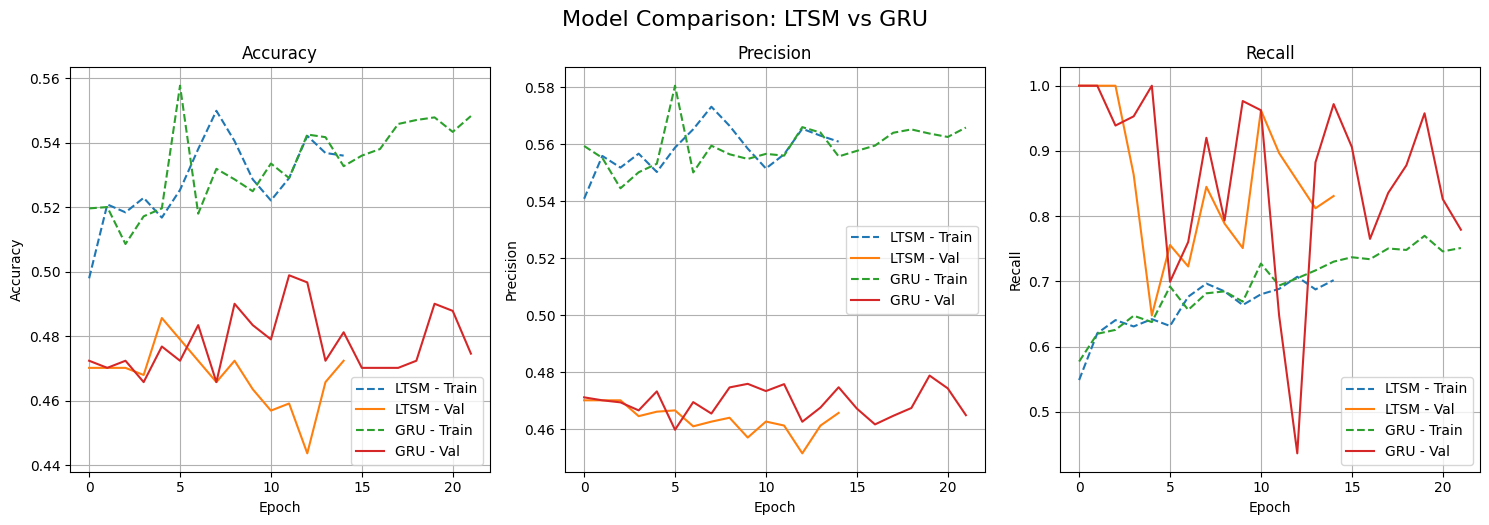

In [ ]:
# Define metrics to compare
metrics = ['accuracy', 'precision', 'recall']

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Plot LTSM
    ax.plot(ltsm_history.history[metric], label='LTSM - Train', linestyle='--')
    ax.plot(ltsm_history.history[f'val_{metric}'], label='LTSM - Val')

    # Plot GRU
    ax.plot(gru_history.history[metric], label='GRU - Train', linestyle='--')
    ax.plot(gru_history.history[f'val_{metric}'], label='GRU - Val')

    ax.set_title(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle("Model Comparison: LTSM vs GRU", fontsize=16, y=1.04)
plt.show()

### Interpretation

<p>The graphs above tell us a few stories:</p>

<ul>
    <li>Both models consistently showed patterns of overfitting, such as:
        <ul>
            <li>Increasing accuracy, precision and recall on the training data while decreasing accuracy, precision and recall on the validatioon data.</li>
            <li>Large gap between the training performance and the validation performance</li>
        </ul>
    </li>
    <li>The GRU model was quicker to converge, which makes sense as it has fewer parameters
</ul>

<p>Given the best LMST RNN had the following performance:</p>
<code>val_accuracy: 0.4812 - val_loss: 0.7053 - val_precision: 0.4676 - val_recall: 0.7465</code>

<p>And the best GRU RNN had the following performance:</p>
<code>val_accuracy: 0.5011 - val_loss: 0.6954 - val_precision: 0.4758 - val_recall: 0.6009</code>

<p>We can conclude:</p>
    <li>The GRU RNN outperformed the LTSM RNN with higher validation accuracy and precision while having lower validation loss, both by comparing the best models and overall</li>
    <li>However, the LTSM had better validation recall when comparing the best models</li>
    <li>Thus, which model to choose will be dependent on the use case; if false negatives need to be avoided (cancer detection), then the LTSM will be the better model. Otherwise, the GRU will be slightly better.
</ul>

<p><strong>We conclude that the GRU RNN was the best overall model, and we will tune the hyperparameters of this model.</strong></p>

<p>In order to tune the hyperparameters of this model, we will use the keras_tuner (kt) library to do a random search trying different hyperparameters.</p>

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(TIME_STEPS, train_X.shape[2])))
    model.add(
        layers.GRU(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            return_sequences=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Choice('dropout', [0.2, 0.3, 0.5])))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='gru_tuner',
    project_name='gru_hyperparameter_tuning'
)

tuner.search(train_X, train_y, validation_data=(val_X, val_y), epochs=20, batch_size=32)

Trial 10 Complete [00h 00m 28s]
val_accuracy: 0.5143488049507141

Best val_accuracy So Far: 0.5739514231681824
Total elapsed time: 00h 04m 10s


In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print them
print(best_hp.values)

{'units': 160, 'dropout': 0.3, 'learning_rate': 0.001}


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 160)            │        81,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,921 (320.00 KB)

 Trainable params: 81,601 (318.75 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
# Set up model checkpoints
best_checkpoint = ModelCheckpoint(
    filepath='best_best_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

# Run best model
best_history = best_model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[best_checkpoint, early_stopping]
)

Epoch 1/30
75/77 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5380 - loss: 0.7020 - precision: 0.5628 - recall: 0.7173
Epoch 1: val_accuracy improved from -inf to 0.48786, saving model to best_best_model.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5383 - loss: 0.7021 - precision: 0.5629 - recall: 0.7174 - val_accuracy: 0.4879 - val_loss: 0.7092 - val_precision: 0.4759 - val_recall: 0.8826
Epoch 2/30
74/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5494 - loss: 0.7092 - precision: 0.5753 - recall: 0.7104
Epoch 2: val_accuracy did not improve from 0.48786
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5493 - loss: 0.7091 - precision: 0.5749 - recall: 0.7116 - val_accuracy: 0.4746 - val_loss: 0.7031 - val_precision: 0.4696 - val_recall: 0.9061
Epoch 3/30
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5467 - loss: 0.7027 - precision: 0.5667 - recall: 0.7011
Epoch 3: val_accuracy did not improve from 0.48786
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5463 - loss: 0.7028 - precision: 0.5665 - recall: 0.7010 - val_accuracy: 0.4834 - val_loss: 0.7094 - val_precision: 0.4764 - val_recall: 0.9953
Epoch 4/30
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5200 - loss: 0.7030 - precision: 0.5409 - recall: 0.7096 - val_accuracy: 0.4901 - val_loss: 0.7016 - val_precision: 0.4737 - val_recall: 0.7606
Epoch 5/30
74/77 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5522 - loss: 0.6942 - precision: 0.5722 - recall: 0.7407
Epoch 5: val_accuracy did not improve from 0.49007
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5524 - loss: 0.6941 - precision: 0.5723 - recall: 0.7406 - val_accuracy: 0.4812 - val_loss: 0.6982 - val_precision: 0.4580 - val_recall: 0.5634
Epoch 6/30
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5484 - loss: 0.6929 - precision: 0.5769 - recall: 0.7486
Epoch 6: val_accuracy improved from 0.49007 to 0.49448, saving model to best_best_model.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5490 - loss: 0.6927 - precision: 0.5766 - recall: 0.7493 - val_accuracy: 0.4945 - val_loss: 0.7006 - val_precision: 0.4769 - val_recall: 0.7746
Epoch 7/30
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5574 - loss: 0.6932 - precision: 0.5680 - recall: 0.7487
Epoch 7: val_accuracy improved from 0.49448 to 0.49669, saving model to best_best_model.h5


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5572 - loss: 0.6932 - precision: 0.5681 - recall: 0.7486 - val_accuracy: 0.4967 - val_loss: 0.6989 - val_precision: 0.4765 - val_recall: 0.7136
Epoch 8/30
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5619 - loss: 0.6823 - precision: 0.5979 - recall: 0.7263
Epoch 8: val_accuracy did not improve from 0.49669
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5616 - loss: 0.6826 - precision: 0.5971 - recall: 0.7268 - val_accuracy: 0.4680 - val_loss: 0.7044 - val_precision: 0.4605 - val_recall: 0.7653
Epoch 9/30
71/77 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5530 - loss: 0.6888 - precision: 0.5687 - recall: 0.7607
Epoch 9: val_accuracy did not improve from 0.49669
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5524 - loss: 0.6891 - precision: 0.5684 - recall: 0.7599 - val_accuracy: 0.4834 - val_loss: 0.7033 - val_precision: 0.4738 - val_recall: 0.8920
Epoch 10/30
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5680 - loss: 0.6809 - precision: 0.5838 - recall: 0.7767 - val_accuracy: 0.4989 - val_loss: 0.7027 - val_precision: 0.4750 - val_recall: 0.6244
Epoch 11/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5500 - loss: 0.6831 - precision: 0.5687 - recall: 0.7414
Epoch 11: val_accuracy did not improve from 0.49890
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5500 - loss: 0.6831 - precision: 0.5687 - recall: 0.7414 - val_accuracy: 0.4989 - val_loss: 0.7054 - val_precision: 0.4817 - val_recall: 0.8638
Epoch 12/30
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5705 - loss: 0.6807 - precision: 0.5783 - recall: 0.7418
Epoch 12: val_accuracy did not improve from 0.49890
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5703 - loss: 0.6808 - precision: 0.5783 - recall: 0.7415 - val_accuracy: 0.4989 - val_loss: 0.7032 - val_precision: 0.4783 - val_recall: 0.7230
Epoch 13/30
71/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accura

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5604 - loss: 0.6770 - precision: 0.5618 - recall: 0.7649 - val_accuracy: 0.5055 - val_loss: 0.7005 - val_precision: 0.4779 - val_recall: 0.5587
Epoch 15/30
71/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5621 - loss: 0.6820 - precision: 0.5618 - recall: 0.7730
Epoch 15: val_accuracy did not improve from 0.50552
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5637 - loss: 0.6814 - precision: 0.5642 - recall: 0.7726 - val_accuracy: 0.4790 - val_loss: 0.7119 - val_precision: 0.4659 - val_recall: 0.7371
Epoch 16/30
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5771 - loss: 0.6710 - precision: 0.5860 - recall: 0.7503
Epoch 16: val_accuracy did not improve from 0.50552
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5771 - loss: 0.6710 - precision: 0.5862 - recall: 0.7502 - val_accuracy: 0.4879 - val_loss: 0.7116 - val_precision: 0.4609 - val_recall: 0.5258
Epoch 17/30
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accura

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6132 - loss: 0.6537 - precision: 0.6250 - recall: 0.7663 - val_accuracy: 0.5188 - val_loss: 0.7140 - val_precision: 0.4870 - val_recall: 0.4413
Epoch 22/30
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6199 - loss: 0.6467 - precision: 0.6363 - recall: 0.7470
Epoch 22: val_accuracy did not improve from 0.51876
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6197 - loss: 0.6468 - precision: 0.6359 - recall: 0.7471 - val_accuracy: 0.4901 - val_loss: 0.7226 - val_precision: 0.4637 - val_recall: 0.5399
Epoch 23/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6089 - loss: 0.6481 - precision: 0.6274 - recall: 0.7389
Epoch 23: val_accuracy did not improve from 0.51876
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6088 - loss: 0.6482 - precision: 0.6272 - recall: 0.7389 - val_accuracy: 0.5143 - val_loss: 0.7226 - val_precision: 0.4855 - val_recall: 0.5493
Epoch 24/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accurac

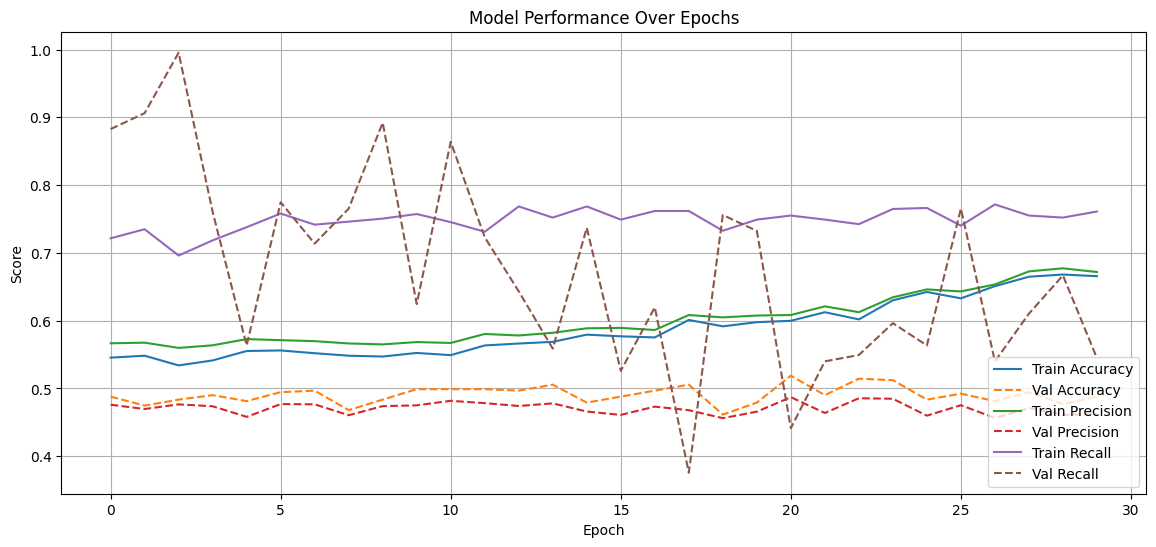

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

# Accuracy
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Val Accuracy', linestyle='--')

# Precision
plt.plot(best_history.history['precision'], label='Train Precision')
plt.plot(best_history.history['val_precision'], label='Val Precision', linestyle='--')

# Recall
plt.plot(best_history.history['recall'], label='Train Recall')
plt.plot(best_history.history['val_recall'], label='Val Recall', linestyle='--')

plt.title('Model Performance Over Epochs')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Run On Testing Dataset

<p>Now that we have our (fairly pathetic) tuned GRU model, we can see how accurate it is on never-before-seen data by testing on our testing dataset.</p>

In [ ]:
# Load the best saved model
best_model = load_model('best_best_model.h5')

# Evaluate
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(test_X, test_y, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5313 - loss: 0.7083 - precision: 0.5967 - recall: 0.3508
Test Loss: 0.7273
Test Accuracy: 0.5110
Test Precision: 0.5667
Test Recall: 0.2179


# Conclusion

<p><strong>Summary: </strong>In this notebook, we:</p>

<ul>
    <li>Overviewed the problem and the dataset</li>
    <li>Explored and cleaned the dataset</li>
    <li>Built a basic LSTM RNN</li>
    <li>Built a basic GRU RNN</li>
    <li>Compared the two models</li>
    <li>Tuned the hyperparameters of the GRU model</li>
    <li>Predicted the test data labels using the GRU model</li>
</ul>

<p><strong>Results and Takeaways: </strong>From this, we saw:</p>

<ul>
    <li>Both models were overfit</li>
    <li>Neither model performed particularly well</li>
    <li>The tuned GRU model had an accuracy of 51.1% on the test dataset, which is barely greater than random chance (50%).</li>
</ul>

<p><strong>Limitations: </strong>Some of the limitations of this notebook include:</p>

<ul>
    <li>Bitcoin prices are very volitile and impacted by many factors outside of recent performance (geopolitics, media exposure, Governmental acceptance, etc.). It is almost impossible to predict the upcoming value based solely on previous days values.</li>
</ul>

<p><strong>Next Steps: </strong>If we were to continue iterating, some possible next steps include:</p>

<ul>
    <li>Add more input variables, such as:
      <ul>
        <li>News headlines for that day</li>
        <li>Other cryptocurrency US Dollar values (Etherium, Avalanche, XRP, etc.)</li>
        <li>Social media references to Bitcoin</li>
        <li>Stock market data</li>
      </ul>
    </li>
</ul>

# Works Cited
[1] "yfinance 0.2.56", ranaroussi, "Download market data from Yahoo! Finance's API", last updated April 23, 2025. https://pypi.org/project/yfinance/.<br>
[2] Ibid.<br>
[3] Entire notebook was assisted by ChatGPT and Google Gemini.